In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy as ap
from scipy.stats import binned_statistic_dd
from scipy.stats import linregress

# Atmospheric Prioritization

The goal of this code is to find planets which are good candidates for atmospheric follow-up. We are particularly interested in planets which are from poorly-covered regions of parameter space (e.g., smaller than previously-known planets, or around different types of star). Because the code was developed for TESS planets, we impose a cutoff at 11.2 R_e. If you change that, beware of the breakdown of the empirical mass-radius relationship for larger planets; you will need to implement a statistical model, e.g. mr_forecaster by Chen & Kipping 2017. 

In [2]:
from priority_tools import *

# Loading the Necessary Data

The first thing to do is get all the data set up. You need to load in the toi+ list (data/toi/toi+-...), where ... is the date of the most recent data release. If you are curious about previous releases, some of them are also in that directory. You also need the TIC star info, which has V, J, and K magnitudes that are missing from TOI+. 

In [3]:
#generate the key names for all the TOI+ columns we need
rp_key,ms_key,pp_key,Ts_key,ars_key,Jmag_key,\
    Vmag_key,rs_key,dec_key,Fp_key,mp_key,\
    mp_units,id_key = tess_colnames()

#load the TOI+ list
toiplus = pd.read_csv('data/toi/toi+-2020-01-15.csv',
                      delimiter=',',header=4)

#load the TIC star info
TIC_info = pd.read_csv('data/exofop/TIC_star_info_jan_15_all.csv',
                       delimiter=',',header=10)

#run the data cleaning function 
tess = clean_tess_data(toiplus, TIC_info)

#load the known planets (and Kepler PCs) table, and merge it
kps = pd.read_csv(r'data/known_planets_and_pcs.csv')
d = tess.append(kps[kps['K_amp'] > 1.5],sort=False) 
    #the K_amp cut wasn't made in the data itself, but is 
    #necessary to cut some of those not-real long-period
    #KOIs as well as known planets for which we can't get masses

# Binning

With all the data loaded, we can run the binning function and generate the pandas dataframe object that we can use for the rest of the analysis. 

In [4]:
#defining the bins: log-uniform in radius and Fp, 
#uniform in Teff. Right now, you need 6 bin edges
#for radius and Fp and 4 for Teff; we can change
#that by editing the "labels" in binning_function
rad_bins = 10**(np.linspace(0,1.05,6)) 
fpl_bins = 10**(np.linspace(-1,4,6))
tef_bins = np.array([2500,3900,5200,6500])
bins = [rad_bins, fpl_bins, tef_bins]

b = binning_function(d, bins) #b stands for "binned", 
                            #to make use easier

# Playing With The Data

Now, we can start looking at the data! Two very simple things we might want to do are look at a single TOI, and look at it in the context of its bin. If you've used pandas before, messing around with these data will be straightforward; if not, here are some useful tricks. To load a single object, use: b[b[id_key] == x], where x is the ID number including .01 or .02 (or .03, or whichever planet you want if it's a highly multiple system)

In [5]:
#make sure we can see the columns in the middle of the output
pd.options.display.max_columns = 100 

#call the request
b[b[id_key] == 1135.01]

#the output tells us the radius, insolation, and Teff bins, as
#well as all the data from the TOI plus list and values that
#we've calculated

,,,Source Pipeline,TIC,Full TOI ID,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Signal ID,Star Radius Value,Star Radius Error,Planet Radius Value,Planet Radius Error,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Alerted,Edited,Stellar Mass,pl_masses,Ars,K_amp,Target,RA,Dec,V mag,J mag,H mag,TSM,Unnamed: 0,radius_bin,insol_bin,st_Teff_bin,priority
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,4,3,spoc,154872375.0,1135.01,193.395514,85.129473,9.029,0.006,1684.151629,0.00066,8.02802,0.00035,4.480524,0.087,5816.770203,0.330706,14,NaN,4.38,0.08,1.0,1.15415,0.03,9.001699,0.23487,1011.007289,5962.7,68.6,246.909698,75.85142,NaN,2019-08-27 16:09:24+0000,2019-12-17 15:43:39+0000,1.164534,60.187467,15.384734,17.396112,154872375.0,193.39637,85.129495,9.54,8.458,8.265,228.782967,NaN,5,4,3,1.0


In [6]:
#you can also ask for a few specific columns if you want 
#a much less messy output

b[b[id_key] == 1135.01][[rp_key,Ts_key,Fp_key,'TSM','V mag','priority']]

,,,Planet Radius Value,Effective Temperature Value,Effective Stellar Flux Value,TSM,V mag,priority
radius_bin,insol_bin,st_Teff_bin,,,,,,
5,4,3,9.001699,5962.7,246.909698,228.782967,9.54,1.0


To look at an entire bin, use b.loc[x,y,z], where x, y, and z are the radius, insolation, and Teff bin, respetively. Note that these are 1-indexed, not 0-indexed (sorry). If it's priority values alone you're interested in, scroll all the way to the right. 

In [7]:
#look into this bin, and select only the top 5 (by TSM)
b.loc[5,4,3].head(5)

Source Pipeline          TIC Full TOI ID  \
radius_bin insol_bin st_Teff_bin                                            
5          4         3                      spoc  311035838.0     1419.01   
                     3                      spoc  445859771.0     1273.01   
                     3                      spoc  154872375.0     1135.01   
                     3                      spoc  147950620.0     1194.01   
                     3                       NaN          NaN  WASP-139 b   

                                  TIC Right Ascension  TIC Declination  \
radius_bin insol_bin st_Teff_bin                                         
5          4         3                     206.094141        48.028668   
                     3                     214.120552        58.390445   
                     3                     193.395514        85.129473   
                     3                     167.820482        69.964708   
                     3                            NaN       -41.302147   

                                  TMag Value  TMag Uncertainty  \
radius_bin insol_bin st_Teff_bin                                 
5          4         3               10.7164            0.0061   
                     3               10.4180            0.0060   
                     3                9.0290            0.0060   
                     3               10.4780            0.0060   
                     3                   NaN               NaN   

                                  Orbital Epoch Value  Orbital Epoch Error  \
radius_bin insol_bin st_Teff_bin                                             
5          4         3                    1739.450795             0.000306   
                     3                    1712.346602             0.001110   
                     3                    1684.151629             0.000660   
                     3                    1684.923533             0.000550   
                     3                            NaN                  NaN   

                                  Orbital Period Value  Orbital Period Error  \
radius_bin insol_bin st_Teff_bin                                               
5          4         3                        2.899733              0.000065   
                     3                        4.631438              0.000390   
                     3                        8.028020              0.000350   
                     3                        2.310800              0.000090   
                     3                        5.924262                   NaN   

                                  Transit Duration Value  \
radius_bin insol_bin st_Teff_bin                           
5          4         3                          2.049797   
                     3                          1.577681   
                     3                          4.480524   
                     3                          1.581305   
                     3                               NaN   

                                  Transit Duration Error  Transit Depth Value  \
radius_bin insol_bin st_Teff_bin                                                
5          4         3                          0.026909         12899.986780   
                     3                          0.124000          5198.299419   
                     3                          0.087000          5816.770203   
                     3                          0.219000          6354.142373   
                     3                               NaN                  NaN   

                                  Transit Depth Error Sectors Public Comment  \
radius_bin insol_bin st_Teff_bin                                               
5          4         3                     106.316055      16      HAT-P-3 b   
                     3                     210.631800      15            NaN   
                     3                       0.330706      14            NaN   
              

Let's try the visualization tool, which displays all the objects in a given radius bin. Dots scale linearly with planet radius. Labels indicate the object: floats are TOIs [i.e. "421.01 is TOI 421.01], anything starting with "K0" or "EPIC" is an unconfirmed KOI or K2 object, and everything else is a confirmed planet (including some previously-confirmed TOIs - for example TOI 270c falls into this category). Note that long-period KOIs (i.e., those in the top left - with relatively hot stars but earth-like insolation) are considered unreliable and should not be assumed to actually exist or be good potential atmospheric targets. 

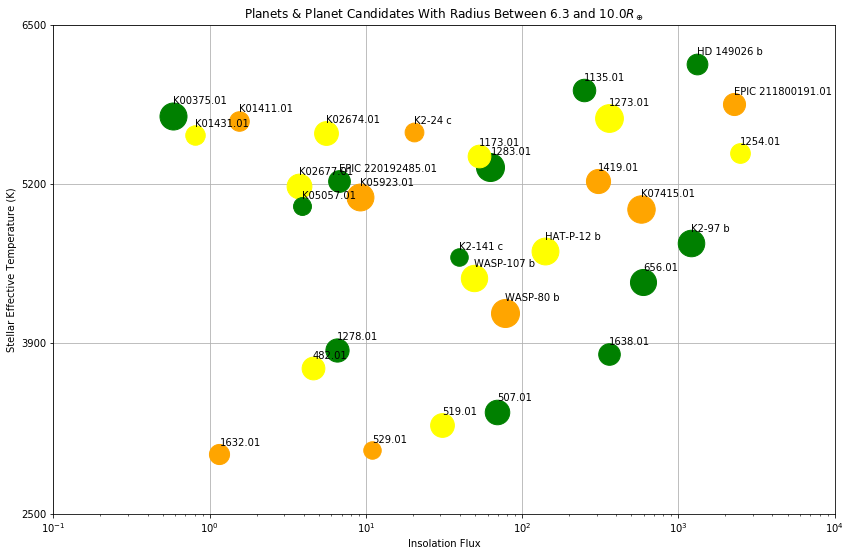

In [14]:
#bin_plotter inputs are the binned data, the bin edges
#(as defined above), and the radius bin of interest
bin_plotter(b,bins,5)